# Warsaw University of Technology
## Course: Artificial Intelligence Fundamentals
## Project: COVID-19 Classification
###   By: Amir Ali & Nadar Tavana 

#### Import Libraries

In [0]:
%tensorflow_version 1.x
from keras.models import load_model
from __future__ import print_function
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
import cv2 
from os import listdir
import numpy as np
import matplotlib. pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D,GlobalAveragePooling2D,Activation,BatchNormalization,Dropout,Concatenate
from keras.models import Model
from keras.applications import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam, Adamax
from keras.callbacks import LearningRateScheduler
from keras import optimizers

#Augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
import urllib,math

TensorFlow 1.x selected.


Using TensorFlow backend.


#### Augmentation

In [0]:
def augment(images,num):
  aug = []
  datagens = []
  datagens.append(ImageDataGenerator(width_shift_range=0.15))
  datagens.append(ImageDataGenerator(height_shift_range=0.15))
  datagens.append(ImageDataGenerator(horizontal_flip=True))
  datagens.append(ImageDataGenerator(rotation_range=45))
  datagens.append(ImageDataGenerator(brightness_range=[0.6,1]))
  datagens.append(ImageDataGenerator(zoom_range=0.15))
  for data in images:
    samples = expand_dims(data, 0)
    for datagen in datagens:
      it = datagen.flow(samples, batch_size=1)
      for i in range(num):
        batch = it.next()
        image = batch[0].astype('uint8')
        aug.append(image)
  return aug

#### Import Dataset

In [0]:
x_train=np.load('/content/drive/My Drive/Corona_Image/Pavel/Data/v3/x_train.npy')
y_train1=np.load('/content/drive/My Drive/Corona_Image/Pavel/Data/v3/y_train.npy')
x_test=np.load('/content/drive/My Drive/Corona_Image/Pavel/Data/v3/x_test.npy')
y_test1=np.load('/content/drive/My Drive/Corona_Image/Pavel/Data/v3/y_test.npy')

In [0]:
print(np.unique(y_train1,return_counts=True))
print(np.unique(y_test1,return_counts=True))

(array([0, 1, 2], dtype=int32), array([7966, 5451,  207]))
(array([0, 1, 2], dtype=int32), array([885, 594,  31]))


In [0]:
def make_two_class(arr):
  arr[arr == 1] = 0
  arr[arr == 2] = 1
  return arr

In [0]:
y_train=make_two_class(y_train1)
y_test=make_two_class(y_test1)
print(np.unique(y_train1,return_counts=True))
print(np.unique(y_test1,return_counts=True))

(array([0, 1], dtype=int32), array([13417,   207]))
(array([0, 1], dtype=int32), array([1479,   31]))


In [0]:
y_train_cat = np_utils.to_categorical(y_train, 2)
train_data, val_data, train_label, val_label = train_test_split(x_train, y_train_cat, test_size=0.1, random_state=42, stratify=y_train_cat)
train_label = np.argmax(train_label,axis=1)
corona = train_data[train_label==1]
aug = np.array(augment(corona,9))
label = np.empty(aug.shape[0],dtype='int32')
label.fill(1)
train_data = np.concatenate((train_data, aug), axis=0)
train_label = np.concatenate((train_label, label), axis=0)
train_data,train_label=shuffle(train_data,train_label)

In [0]:
print(np.unique(train_label,return_counts=True))
train_label = np_utils.to_categorical(train_label, 2)
print(train_data.shape,train_label.shape)

(array([0, 1]), array([12075, 10230]))
(22305, 224, 224, 3) (22305, 2)


In [0]:
val_label = np.argmax(val_label,axis=1)
corona = val_data[val_label==1]
aug = np.array(augment(corona,9))
label = np.empty(aug.shape[0],dtype='int32')
label.fill(1)
val_data = np.concatenate((val_data, aug), axis=0)
val_label = np.concatenate((val_label, label), axis=0)
print(np.unique(val_label,return_counts=True))
val_label = np_utils.to_categorical(val_label, 2)
val_data,val_label=shuffle(val_data,val_label)
print(val_data.shape,val_label.shape)

(array([0, 1]), array([1342, 1155]))
(2497, 224, 224, 3) (2497, 2)


In [0]:
densenet = DenseNet121(weights='/content/drive/My Drive/Corona_Image/chexnet_weights.h5',
        # weights = None ,
        include_top=True,
        input_shape=(224,224,3),classes=14
      )
      
m = densenet.layers[-2].output
predictions = Dense(2, activation='softmax')(m)
model = Model(inputs=densenet.inputs, outputs=predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [0]:
m = Sequential()
m.add(densenet)
m.layers.pop()
m.add(Dense(3, activation='softmax'))

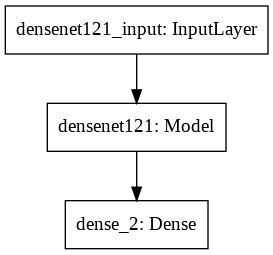

In [0]:
from keras.utils import plot_model
plot_model(m, to_file='model.png')

In [0]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def categorical_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1),
                          K.argmax(y_pred, axis=-1)))


def sparse_categorical_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.max(y_true, axis=-1),
                          K.cast(K.argmax(y_pred, axis=-1), K.floatx())))


def top_k_categorical_accuracy(y_true, y_pred, k=5):
    return K.mean(K.in_top_k(y_pred, K.argmax(y_true, axis=-1), k))


def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))


def mean_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))


def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff)


def mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.mean(K.square(first_log - second_log))


def hinge(y_true, y_pred):
    return K.mean(K.maximum(1. - y_true * y_pred, 0.))


def squared_hinge(y_true, y_pred):
    return K.mean(K.square(K.maximum(1. - y_true * y_pred, 0.)))


def categorical_crossentropy(y_true, y_pred):
    return K.mean(K.categorical_crossentropy(y_pred, y_true))


def sparse_categorical_crossentropy(y_true, y_pred):
    return K.mean(K.sparse_categorical_crossentropy(y_pred, y_true))


def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true))


def kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.mean(K.sum(y_true * K.log(y_true / y_pred), axis=-1))


def poisson(y_true, y_pred):
    return K.mean(y_pred - y_true * K.log(y_pred + K.epsilon()))


def cosine_proximity(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return -K.mean(y_true * y_pred)


def matthews_correlation(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [0]:
adam = Adamax(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy', precision, recall, fbeta_score])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {0: 3, 1: 7}
history = model.fit(train_data, train_label, batch_size=16,
                         epochs=100,verbose=1, validation_data=(val_data,val_label), shuffle=True, class_weight=class_weights,
                           callbacks=[reduce_lr, es])


Train on 22305 samples, validate on 2497 samples
Epoch 1/100
22305/22305 [==============================] - 253s 11ms/step - loss: 2.8933 - accuracy: 0.4787 - precision: 0.4791 - recall: 0.4791 - fbeta_score: 0.4791 - val_loss: 0.6711 - val_accuracy: 0.5655 - val_precision: 0.5621 - val_recall: 0.5621 - val_fbeta_score: 0.5621
Epoch 2/100
22305/22305 [==============================] - 224s 10ms/step - loss: 2.5253 - accuracy: 0.6038 - precision: 0.6034 - recall: 0.6034 - fbeta_score: 0.6034 - val_loss: 0.5710 - val_accuracy: 0.6976 - val_precision: 0.6935 - val_recall: 0.6935 - val_fbeta_score: 0.6935
Epoch 3/100
22305/22305 [==============================] - 223s 10ms/step - loss: 2.1449 - accuracy: 0.7084 - precision: 0.7079 - recall: 0.7079 - fbeta_score: 0.7079 - val_loss: 0.4756 - val_accuracy: 0.7697 - val_precision: 0.7651 - val_recall: 0.7651 - val_fbeta_score: 0.7651
Epoch 4/100
22305/22305 [==============================] - 223s 10ms/step - loss: 1.7670 - accuracy: 0.7879 - 

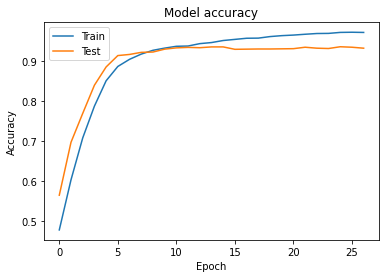

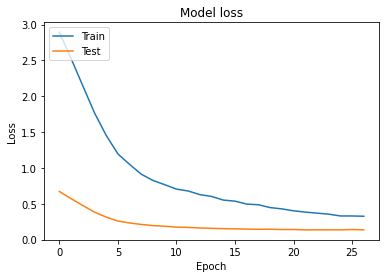

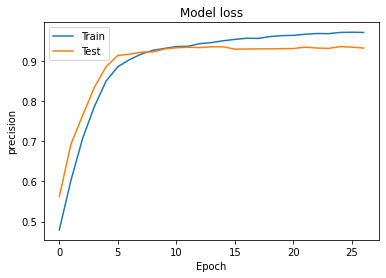

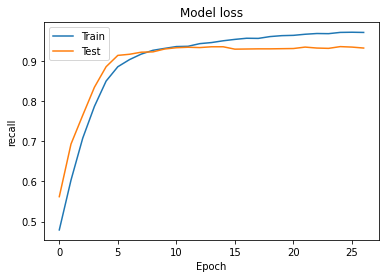

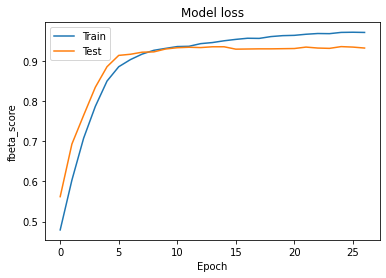

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model loss')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model loss')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['fbeta_score'])
plt.plot(history.history['val_fbeta_score'])
plt.title('Model loss')
plt.ylabel('fbeta_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
y_test_new = y_test
y_test = np_utils.to_categorical(y_test_new, 2)
scores = model.evaluate(x_test, y_test, verbose=0)
print(scores)
      
corona_test = x_test[y_test_new == 1]
corona = model.predict(corona_test)
corona_test_label = y_test[y_test_new == 1]
scores=model.evaluate(corona_test,corona_test_label)
print(scores)

corona_test = x_test[y_test_new == 0]
normal = model.predict(corona_test)
corona_test_label = y_test[y_test_new == 0]
scores=model.evaluate(corona_test,corona_test_label)
print(scores)

corona_classes = np.unique([np.argmax(y, axis=None, out=None) for y in corona], return_counts=True)
normal_classes = np.unique([np.argmax(y, axis=None, out=None) for y in normal], return_counts=True)
print(corona_classes)
print(normal_classes)

[0.10817603277449576, 0.9649006724357605, 0.9626736044883728, 0.9626736044883728, 0.9626736044883728]
31/31 [==============================] - 0s 3ms/step
[0.23326972126960754, 0.9354838728904724, 0.9354838728904724, 0.9354838728904724, 0.9354838132858276]
1479/1479 [==============================] - 4s 3ms/step
[0.10555405643761682, 0.9655172228813171, 0.9637157917022705, 0.9637157917022705, 0.9637157917022705]
(array([0, 1]), array([ 2, 29]))
(array([0, 1]), array([1428,   51]))


In [0]:
model.save('/content/drive/My Drive/Corona_Image/E1_test_train_split/2_class_weight_3_7.h5')

In [0]:
from skimage.transform import resize
def preprocess(img):
  img = img_to_array(img)
  img = np.expand_dims(img,axis=0)
  return img


def grad_cam(image):
  image_1 = preprocess(image)

  predict = model.predict(image_1)
  target_class = np.argmax(predict[0])
  #print("Predicted Class = %d"%target_class)
  #print("Actual Class = %d"%actual_class)
  last_conv = model.get_layer('conv5_block16_concat')
  grads = K.gradients(model.output[:,target_class],last_conv.output)[0]

  pooled_grads = K.mean(grads,axis=(0,1,2))
  iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
  pooled_grads_value,conv_layer_output = iterate([image_1])

  for i in range(1024):
      conv_layer_output[:,:,i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output,axis=-1)

  for x in range(heatmap.shape[0]):
      for y in range(heatmap.shape[1]):
          heatmap[x,y] = np.max(heatmap[x,y],0)

  heatmap = np.maximum(heatmap,0)
  heatmap /= np.max(heatmap)
  # plt.imshow(heatmap)

  heat_map = resize(heatmap, (224,224),preserve_range=True)
  # plt.imshow(image)
  # cs = plt.imshow(upsample,alpha=0.6)
  # cbar = plt.colorbar(cs)
  # plt.show()
  return target_class, heat_map

In [0]:
x_test=np.load('/content/drive/My Drive/Corona_Image/Pavel/Data/v3/x_test.npy')
y_test=np.load('/content/drive/My Drive/Corona_Image/Pavel/Data/v3/y_test.npy')
y_test=make_two_class(y_test)
x_corona = x_test[y_test== 1]
x_normal = x_test[y_test== 0]

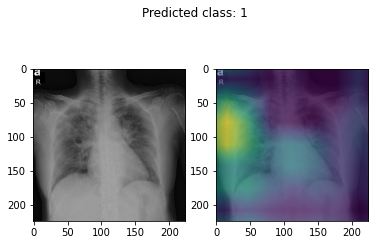

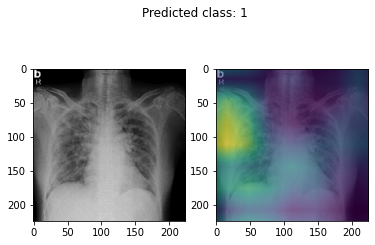

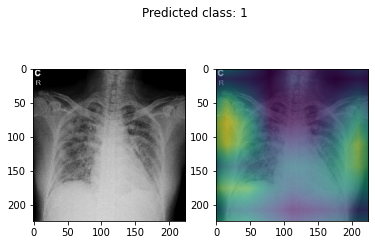

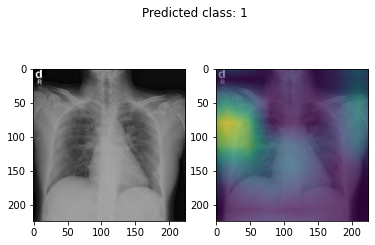

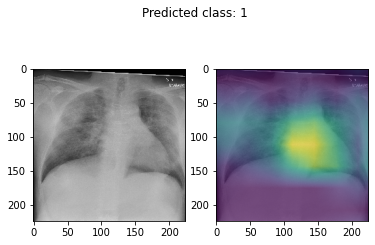

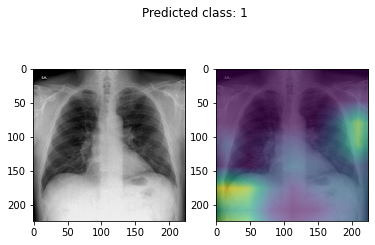

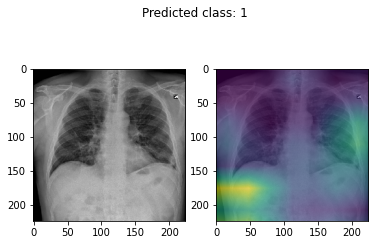

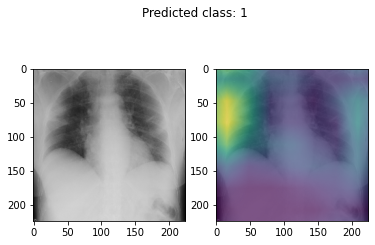

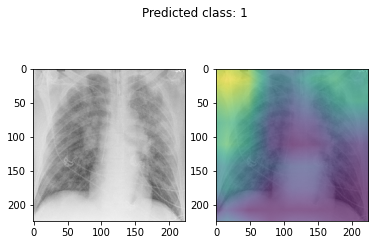

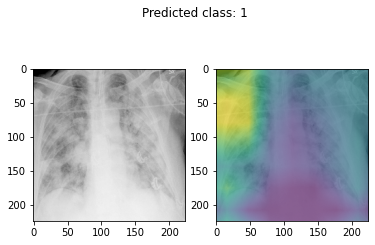

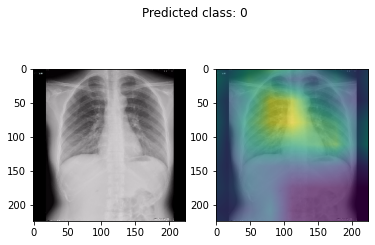

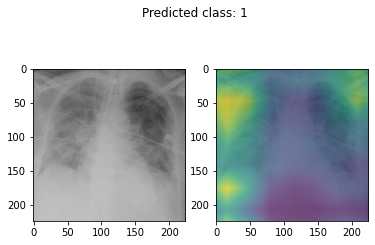

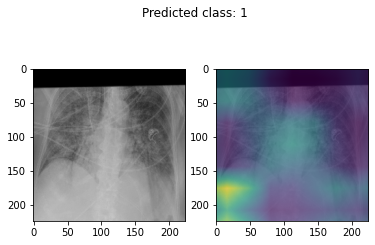

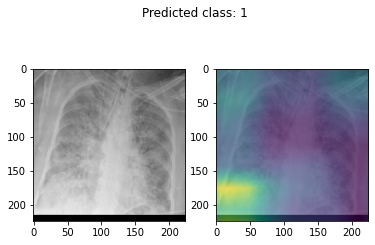

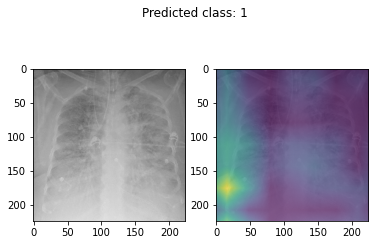

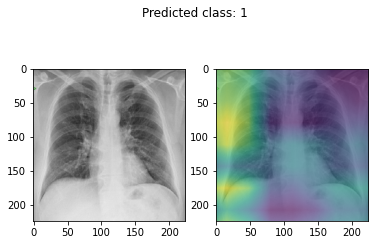

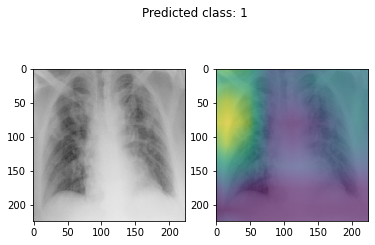

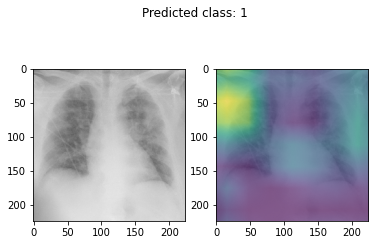

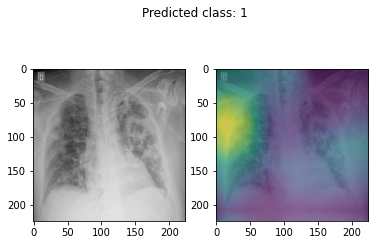

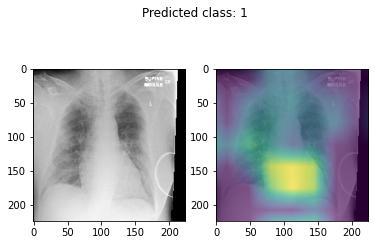

In [0]:
for i in range (20):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  target_class, heat_map = grad_cam(x_corona[i])
  fig.suptitle(f'Predicted class: {target_class}')
  ax1.imshow(x_corona[i])
  ax2.imshow(x_corona[i])
  ax2.imshow(heat_map, alpha=0.6)